In [1]:
"""
Solution for week 6 practice of Data Visualization

Read several files of plain English text
Gnerate a list of words, counts, bounding box sizes, and word offsets
Save using pickle for easy loading in project6

If this solution throws an error, try executing nltk.download(['punkt', 'stopwords', 'wordnet']) once.
"""

# On Vocareum, this is a Python 3.5 notebook due to an issue with importing nltk in Python 3.6
# This code updates sys.path to remove all paths containing "3.6" so the notebook runs correctly
# This code should be commented out when running on your desktop
import sys
sys.path = [path for path in sys.path if "3.6" not in path]

# Regular imports
import random
import collections
import nltk
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dill as pickle

In [2]:
# Resource paths
DATA_PATH = "../data/"

In [3]:
#############################################################
# Use nltk to compute word counts from plain text

def compute_counts(file_name, extra_stop_words, num_words, lemmatized=False, plot=False):
    """
    Input: string file_name, list extra_stop_words of strings, optional booleans lemmatized, plot
    
    Output: OrderedDict with items (word, count) of size length num_words 
    where count is number of times word appears in the plain text with stop words removed
    """
    
    # Read text from file_name, tokenize, keep alphabetical words, move to lowercase
    file = open(file_name, "rt")
    raw_text = file.read()
    tokenized_words = nltk.tokenize.word_tokenize(raw_text)
    raw_words = [word.lower() for word in tokenized_words if word.isalpha()]
    
    # Load stop words
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend(extra_stop_words)
    cleaned_words = [word for word in raw_words if word not in stop_words]
    
    # lemmatize if required
    if lemmatized:
        # Convert common words such as "state" and "states" to root word
        lemmatizer = nltk.stem.WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in cleaned_words]
        words = lemmatized_words
    else:
        words = cleaned_words

    # Compute and optionally plot word counts)
    freqs = nltk.FreqDist(words)
    if plot:
        freqs.plot(num_words, cumulative=False)
    word_counts = collections.OrderedDict(freqs.most_common(min(num_words, len(words))))
    return word_counts
    

In [4]:
#############################################################################
# Use matplotlib to compute bounding boxes for words based on their counts

PLOT_RANGE = [-1, 1]
FIG_SIZE = 8


def compute_box_info(box, word_pos, axs):
    """
    Input: matplotlib textbox box, tuple of floats word_pos, matplotlib Axes axs
    
    Output: Tuple (box_size, word_offset) consisting of box size and offset from lower left of box to
    lower left of word
    
    NOTE: Textbox must have been rendered prior to this call
    """
        
    rendered_box = box.get_window_extent()
    fig_min = (rendered_box.xmin, rendered_box.ymin)
    fig_max = (rendered_box.xmax, rendered_box.ymax)  
    box_min = axs.transData.inverted().transform(fig_min)  
    box_max = axs.transData.inverted().transform(fig_max)   
    box_size = ((box_max[0] - box_min[0]), (box_max[1] - box_min[1]))
    word_offset = (word_pos[0] - box_min[0], word_pos[1] - box_min[1])
    return box_size, word_offset

In [5]:
def compute_boxes(word_counts, font_scale):
    """
    Input: OrderedDict word_counts with items (word, count) pairs, integer font_scale
    
    Output: OrderedDict with items (word (font_size, box_size, word_off))) where
    font_size is the count times font_scale
    box_size is tuple of floats corresponding to size of text box in data coordinates
    word_off is tuple of floats corresponding to offset from lower left of text box
    to lower left of word position
    """

    # Initial plot
    fig, axs = plt.subplots()
    fig.set_figheight(FIG_SIZE)
    fig.set_figwidth(FIG_SIZE)
    axs.set_xlim(PLOT_RANGE)
    axs.set_ylim(PLOT_RANGE)   
    
    # Plot word to generate textboxes
    text_boxes = collections.OrderedDict()
    for word in word_counts:
        text_boxes[word] = axs.text(0.0, 0.0, word,
                                    fontsize=word_counts[word] * font_scale)
        
    plt.show()     
    #plt.savefig("junk.png", dpi=fig.dpi)
    plt.close()
    
    # Compute box info
    word_boxes = collections.OrderedDict()
    for word in word_counts:
        box_size, word_offset = compute_box_info(text_boxes[word], (0.0, 0.0), axs)
        word_boxes[word] = (word_counts[word] * font_scale, box_size, word_offset)
    return word_boxes

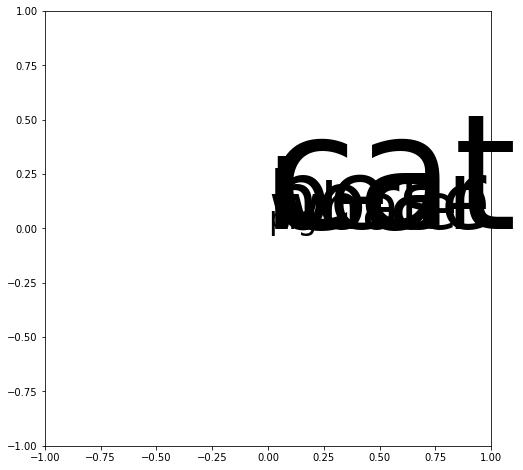

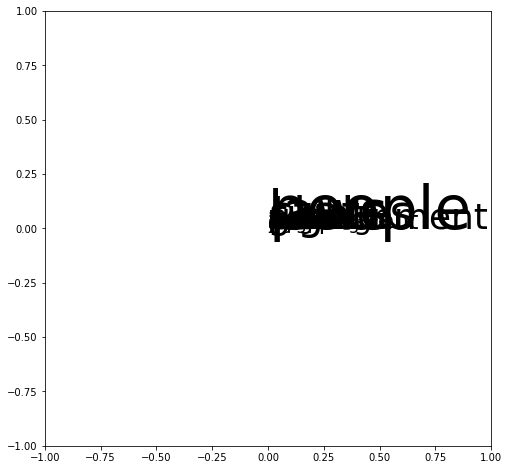

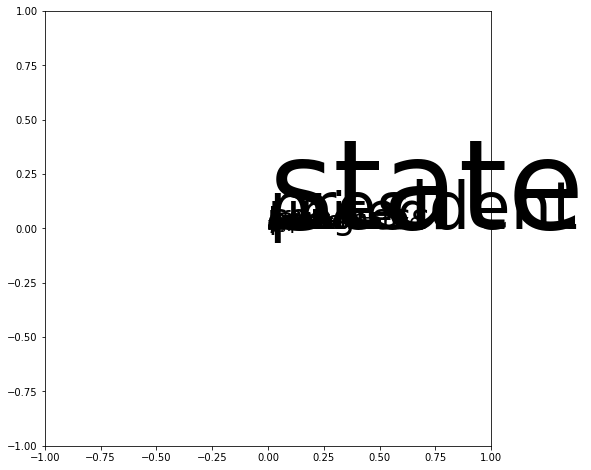

In [6]:
####################################################################
# Use pickle to save serialized dictionary of word boxes for 3 examples

def build_word_boxes():
    """
    Build and save word boxes in pickle file for use in project6
    """
    
    word_boxes = {}
    animal_counts = compute_counts(DATA_PATH + "animals.txt", [], 5, lemmatized=True)
    word_boxes["animals"] = compute_boxes(animal_counts, 8)
    
    declaration_counts = compute_counts(DATA_PATH + "declaration.txt", ["us"], 35, lemmatized=False, plot=False)
    word_boxes["declaration"] = compute_boxes(declaration_counts, 6)
    
    constitution_counts = compute_counts(DATA_PATH + "constitution.txt", ["shall", "may"], 92, lemmatized=True, plot=False)
    word_boxes["constitution"] = compute_boxes(constitution_counts, 0.6)
    
    with open(DATA_PATH + "project6_boxes_practice.pickle", 'wb') as file:
        pickle.dump(word_boxes, file)  
    
build_word_boxes()